In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')

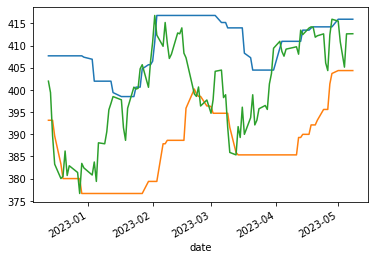

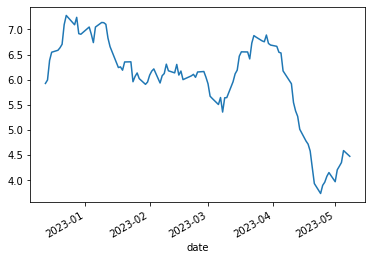

In [2]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()


df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


df1 = df[-100:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [7]:
bt = backTester()
df = df.dropna()
bt.set_asset(df)

long_entry = df['20_up_bound'].to_numpy()
short_entry = df['20_low_bound'].to_numpy()
long_exit = df['10_low_bound'].to_numpy()
short_exit = df['10_up_bound'].to_numpy()
atr = df['ATR'].to_numpy()

for i in range(len(bt.df)):
    order_quantity = 0
    order_price = 0
    risk_unit = int(bt.portfolio_value * 0.01 / (2 * atr[i]))
    if len(bt.open_trades) == 0:
        if bt.high[i] > long_entry[i]:
            order_price = bt.high[i]
            order_quantity = long_entry[i]

        open_trade = True
        stop_loss = order_price - atr[i] * 2
        
    else:
        stop_loss = max(stop_loss, bt.high[i] - 2 * atr[i])
        if bt.low[i] < stop_loss:
            order_quantity = -bt.open_trades[0].quantity
            order_price = stop_loss
            stop_loss = 0
            open_trade = False
            bt.open_trades = []
            

    bt.take_action(order_quantity=order_quantity, order_price=order_price, **{'open_trade': open_trade})

        


AssertionError: no open trades but position != 0

c:\Users\alexr\simple_backtester\utils\misc.py:72: RuntimeWarning: invalid value encountered in scalar power
  return total_return ** (365.25 / num_days)


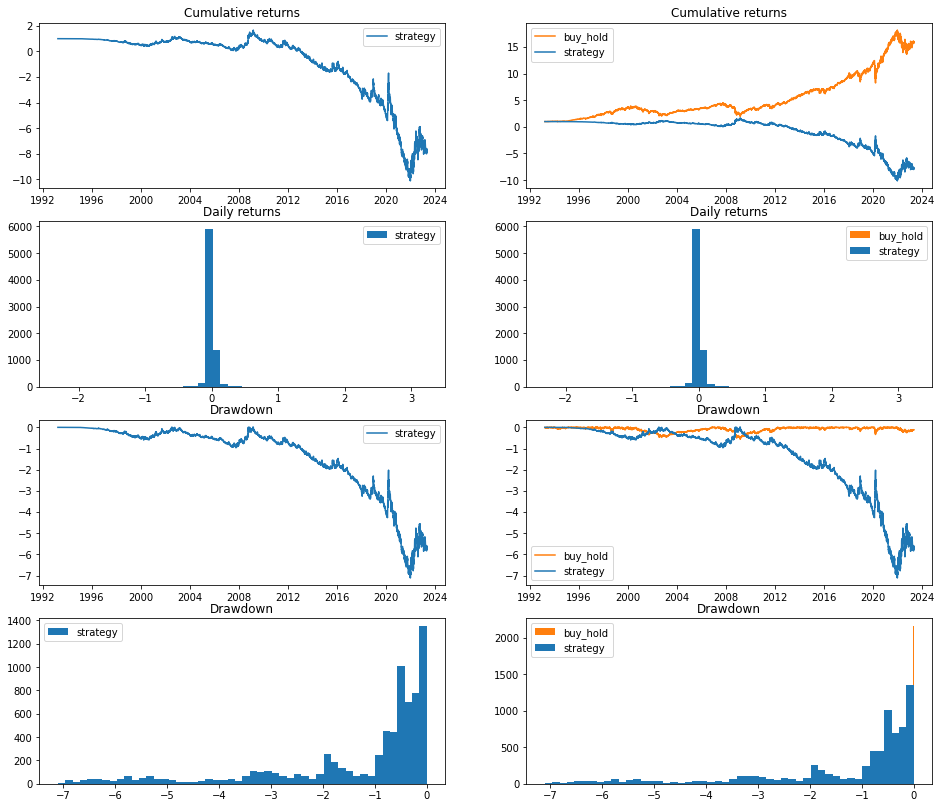

In [4]:
bt.analyse()
bt.plot_graphs()

In [5]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          nan
buy_hold annual return:     0.0964245000107764
Annualised vol:             1.2826882689099046
buy_hold annual vol:        0.18923549737496273
Sharpe ratio:               nan
buy_hold Sharpe ratio:      0.5095476342882701


In [6]:
bt.trade_record.analyse()
bt.trade_record.stats

ZeroDivisionError: division by zero

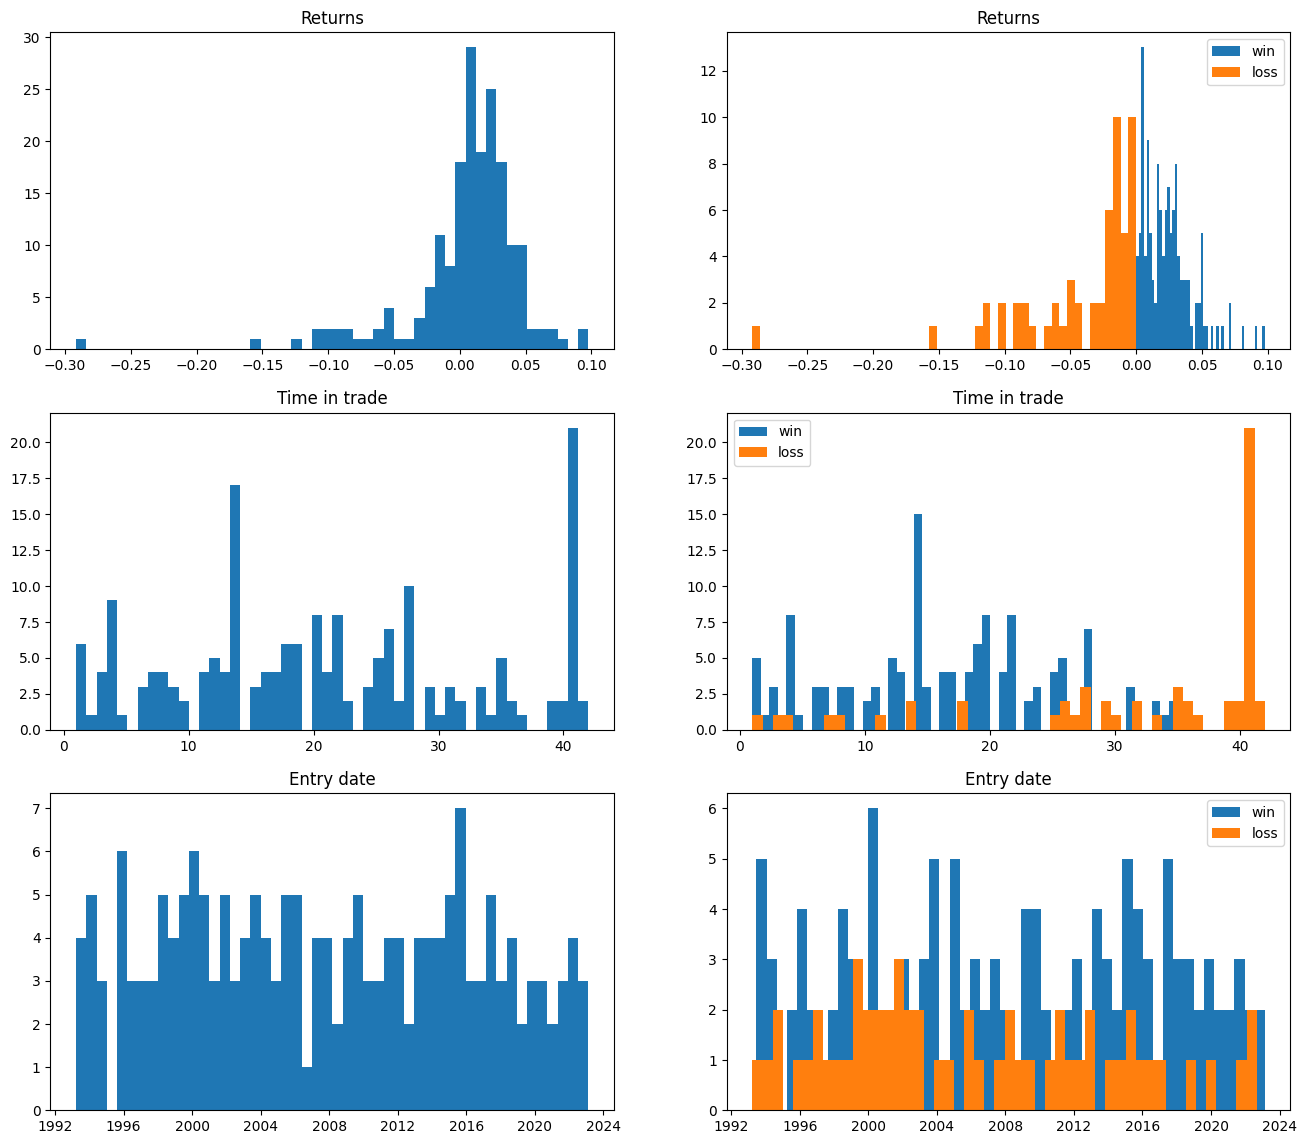

In [ ]:
bt.trade_record.plot_graphs()

<Axes: >

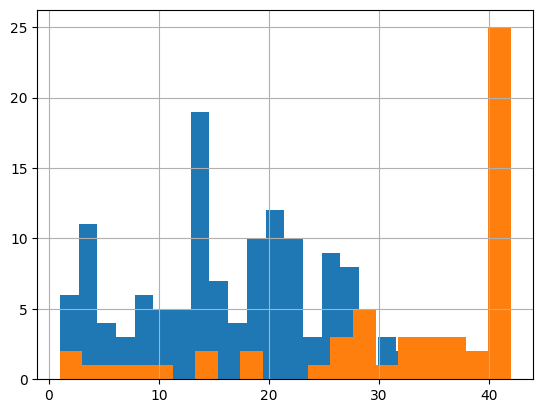

In [ ]:
bt.trade_record.win_records['time_in_trade'].hist(bins=20)
bt.trade_record.loss_records['time_in_trade'].hist(bins=20)

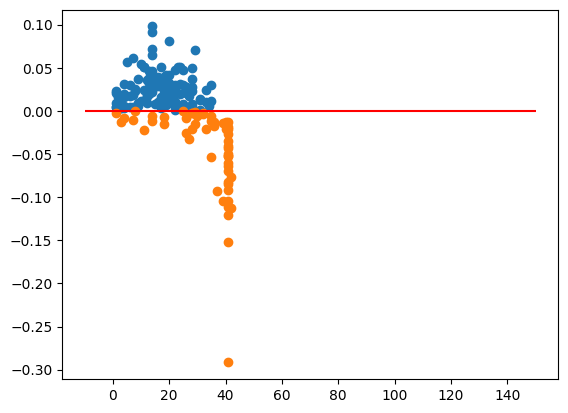

In [ ]:
plt.scatter(bt.trade_record.win_records['time_in_trade'], bt.trade_record.win_records['returns'])
plt.scatter(bt.trade_record.loss_records['time_in_trade'], bt.trade_record.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')